In [1]:
import numpy as np     
import pandas as pd

In [2]:
from sklearn.preprocessing import MinMaxScaler, Normalizer

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import random

In [5]:
import umap
import hdbscan

# Load the data

## Metadata

Information like age of the animal, drugs admiistered, details of light-stimuli used etc are stored in a pickle file which was created using ```eda_metadata.ipynb```.
We can load that data and use these information to select subsets of data for our analysis. 
This would allow us to compare the use of clusters across drugs,light-stimuli and age factors. 

In [38]:
df_meta = pd.read_pickle('../../data/amphioxus_metadata_fina500.pickle')

In [39]:
# create a filename column to match with the filename column in the dataset
df_meta['filename'] = df_meta['filename_video'].apply(lambda x: x.split('.avi')[0])

In [40]:
df_meta.columns

Index(['path_to_video', 'filename_video', 'date', 'time', 'light', 'drugs',
       'duration', 'age', 'stim_on', 'stim_off', 'stim_RGB', 'dlc_result_file',
       'filename'],
      dtype='object')

In [41]:
df_meta.light.unique()

array(['None', 'Light'], dtype=object)

# Loading data : featureset 

In [42]:
df = pd.read_hdf('../../results/pickled_featureset_v3.h5', key='features')

### Thresholding ```speed_MOUTH```

This is should ideally be done while creating the feature dataset. 
Since the ```speed_MOUTH``` feature has not been previously processed for outlier detection, I am doing it here using simple thresholding


<AxesSubplot:>

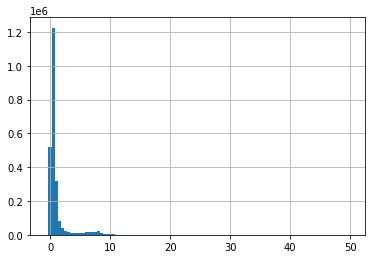

In [43]:
df[df['speed_MOUTH'] < 50]['speed_MOUTH'].hist(bins=100)

- From the histogram it seems like **20** is a reasonable threshold.
- Also since **NaN values** of ```speed_MOUTH``` can be meaningful, cannot remove the rows where ```df[speed_MOUTH].isna()``` is True. 

In [44]:
df = df[(df['speed_MOUTH'].isna())|(df['speed_MOUTH'] < 20)]

## Get features from wildtype (control) animals 

In [45]:
df_merged = df.merge(df_meta, how='left', on='filename')

In [46]:
df_control = df_merged[(df_merged['age'] > 50)&(df_merged['drugs']=='none')&(df_merged['light']=='None')]

In [ ]:
print(f'Number of control/ wildtype videos :{len(df_control.filename.unique())}')

## Preprocessing : Normalizing or Scaling the features

Since each of the biophysical measures have different value ranges and scales, I think it would be better to normalize them so that each of the feature has same weightage when we perform dimensionality reduction and clustering. 
- This is frequently done before PCA
- Is it required in the case of UMAP ?

What can be done is a comparison of the UMAP results with and without scaling of the features.

In [ ]:
df_prep = df.copy() #deep copy

### Curvatures

Since curvatures can be positive and negative, it might be better to use a scaler in [-1, 1] range, so that -ve & +ve curvatures are better distinguishable.

In [ ]:
cols_curv = list(df_prep.filter(like='curv').columns)

In [ ]:
df_prep[cols_curv] = MinMaxScaler(feature_range=(-1,1)).fit_transform(df_prep[cols_curv])

### Speeds

In [ ]:
cols_speed = list(df_prep.filter(like='speed').columns)

Since speeds cannot have negative value, using a MinMaxScaler in [0, 1] (default) range should be good

In [ ]:
df_prep[cols_speed] = MinMaxScaler().fit_transform(df_prep[cols_speed])

### Quirkiness

In [ ]:
df_prep['quirkiness'] = pd.DataFrame(MinMaxScaler().fit_transform(df_prep['quirkiness'].values.reshape(-1,1)), index=df_prep.index)

### Preprocessed control dataset

In [ ]:
df_prep_merged = df_prep.merge(df_meta, how='left', on='filename')

In [ ]:
df_prep_control = df_prep_merged[(df_prep_merged['age'] > 50)&(df_prep_merged['drugs']=='none')&(df_prep_merged['light']=='None')]

In [ ]:
print(f'Number of control/ wildtype videos :{len(df_prep_control.filename.unique())}')

# Selecting features to be used for clustering 

In [47]:
df_control.columns

Index(['len_NT_to_TT', 'len_sum_of_parts', 'len_mean_of_parts', 'curv_NT',
       'curv_DH1', 'curv_DH2', 'curv_DNP', 'curv_DTP1', 'curv_DTP2',
       'curv_DTP3', 'curv_DTP4', 'curv_DTP5', 'curv_DTP6', 'curv_DTP7',
       'curv_DTP8', 'curv_DTP9', 'curv_DTP10', 'curv_TT', 'quirkiness',
       'speed_NT', 'speed_DH1', 'speed_DH2', 'speed_DNP', 'speed_DTP1',
       'speed_DTP2', 'speed_DTP3', 'speed_DTP4', 'speed_DTP5', 'speed_DTP6',
       'speed_DTP7', 'speed_DTP8', 'speed_DTP9', 'speed_DTP10', 'speed_TT',
       'speed_VTP10', 'speed_VTP9', 'speed_VTP8', 'speed_VTP7', 'speed_VTP6',
       'speed_VTP5', 'speed_VTP4', 'speed_VTP3', 'speed_VTP2', 'speed_VTP1',
       'speed_VNP', 'speed_MOUTH', 'MOUTH', 'filename', 'frame',
       'path_to_video', 'filename_video', 'date', 'time', 'light', 'drugs',
       'duration', 'age', 'stim_on', 'stim_off', 'stim_RGB',
       'dlc_result_file'],
      dtype='object')

In [48]:
# df_control.to_hdf('../../results/featureset_used_for_UMAPclustering_18072023.h5', key='features_clean')

In [49]:
cols_speed = list(df_control.filter(like='speed').columns)
feats_to_use = cols_speed #+ cols_curv + ['quirkiness']

In [50]:
df_in = df_control[feats_to_use]
# df_in_prep = df_prep_control[feats_to_use]

# NaN masking 

In [51]:
df_in = df_in.fillna(value=-1)

In [ ]:
# df_in_prep = df_in_prep.fillna(value=-0.1)

# UMAP

In [ ]:
reducer = umap.UMAP(min_dist=0.0)

## Without preprocessing

In [ ]:
embedding = reducer.fit_transform(df_in.values)
embedding.shape

## With preprocessing

In [ ]:
reducer_prep = umap.UMAP()

In [ ]:
embedding_prep = reducer_prep.fit_transform(df_in_prep.values)
embedding_prep.shape

## Comparing how UMAP looks when features are scaled and when features aren't

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
axes= axes.ravel()
axes[0].scatter(embedding[:, 0],embedding[:, 1], s=0.2)
# axes[1].scatter(embedding_prep[:, 0],embedding_prep[:, 1], s=0.2)

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(15,15))
axes= axes.ravel()
axes[0].scatter(embedding[:, 0],embedding[:, 1], s=0.2)

hue_feats = {'mouth': df_control['speed_MOUTH'],
             'quirkiness': df_control['quirkiness'],
             'mean_dorsal_speeds': df_control.filter(like='speed_D').mean(axis=1),
             'mean_ventral_speeds': df_control.filter(like='speed_V').mean(axis=1),
             'mean_speeds': df_control.filter(like='speed_').mean(axis=1),
#              'length': df_control['len_sum_of_parts'],
             'mean_curv': df_control.filter(like='curv').abs().mean(axis=1),
             'speed_NT': df_control['speed_NT'],
            }

for i, key_hue in enumerate(hue_feats.keys()):
    axes[i+1].scatter(embedding[:, 0],embedding[:, 1], c= hue_feats[key_hue], s=0.2)
    axes[i+1].set_title(key_hue)
for ax in axes:  
    ax.set_aspect('equal', 'datalim')
fig.savefig('../../results/umap_comparisons/umap_raw_feat_distributions_v2.png')

In [ ]:
df_control['umap_raw_0'] = embedding[:,0]
df_control['umap_raw_1'] = embedding[:,1]

In [ ]:
df_control.filter(like='umap').to_hdf('../../results/UMAPclustering_18072023_2118.h5', key='features_with_results')

In [ ]:
# fig, axes = plt.subplots(3,3, figsize=(15,15))
# axes= axes.ravel()
# axes[0].scatter(embedding_prep[:, 0],embedding_prep[:, 1], s=0.2)

# hue_feats = {'mouth': df_in_prep['speed_MOUTH'],
#              'quirkiness': df_in_prep['quirkiness'],
#              'mean_dorsal_speeds': df_in_prep.filter(like='speed_D').mean(axis=1),
#              'mean_ventral_speeds': df_in_prep.filter(like='speed_V').mean(axis=1),
#              'mean_speeds': df_in_prep.filter(like='speed_').mean(axis=1),
# #              'length': df_in_prep['len_sum_of_parts'],
#              'mean_curv': df_in_prep.filter(like='curv').abs().mean(axis=1),
#              'speed_NT': df_in_prep['speed_NT'],
#             }

# for i, key_hue in enumerate(hue_feats.keys()):
#     axes[i+1].scatter(embedding_prep[:, 0],embedding_prep[:, 1], c= hue_feats[key_hue], s=0.2)
#     axes[i+1].set_title(key_hue)
# for ax in axes:  
#     ax.set_aspect('equal', 'datalim')
# fig.savefig('../results/umap_comparisons/umap_prep_feat_distributions.png')

Seems like the UMAP space looks good without preprocessing. 
- TODO: 
    - Think of how preprocessing affects the distances
    - Also, need to check how UMAP space changes according to min_dist, n_neigbors and metric arguments

## UMAP parameters

In [ ]:
reducer_maha = umap.UMAP(metric= 'mahalanobis')

In [ ]:
embedding_maha = reducer_maha.fit_transform(df_in.values)
embedding_maha.shape

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
axes= axes.ravel()
axes[0].scatter(embedding[:, 0],embedding[:, 1], s=0.2)
axes[1].scatter(embedding_maha[:, 0],embedding_maha[:, 1], s=0.2)

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(15,15))
axes= axes.ravel()
axes[0].scatter(embedding_maha[:, 0],embedding_maha[:, 1], s=0.2)

hue_feats = {'mouth': df_in['speed_MOUTH'],
             'quirkiness': df_in['quirkiness'],
             'mean_dorsal_speeds': df_in.filter(like='speed_D').mean(axis=1),
             'mean_ventral_speeds': df_in.filter(like='speed_V').mean(axis=1),
             'mean_speeds': df_in.filter(like='speed_').mean(axis=1),
#              'length': df_in['len_sum_of_parts'],
             'mean_curv': df_in.filter(like='curv').abs().mean(axis=1),
             'speed_NT': df_in['speed_NT'],
            }

for i, key_hue in enumerate(hue_feats.keys()):
    axes[i+1].scatter(embedding_maha[:, 0],embedding_maha[:, 1], c= hue_feats[key_hue], s=0.2)
    axes[i+1].set_title(key_hue)
for ax in axes:  
    ax.set_aspect('equal', 'datalim')
fig.savefig('../../results/umap_comparisons/umap_maha_feat_distributions.png')

# HDBSCAN

In [6]:
# Uplaod UMAP results from saved data
df_results_umap = pd.read_hdf('../../results/UMAPclustering_18072023_2118.h5', key='features_with_results')

In [7]:
embedding = df_results_umap.values
embedding.shape

(1940535, 2)

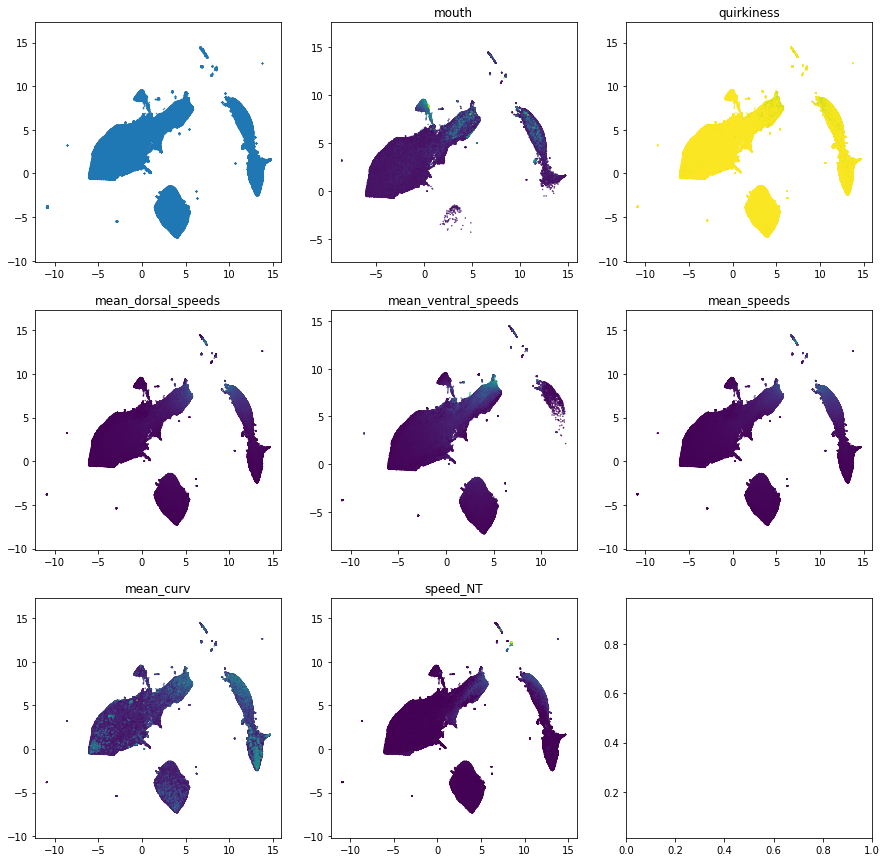

In [52]:
fig, axes = plt.subplots(3,3, figsize=(15,15))
axes= axes.ravel()
axes[0].scatter(embedding[:, 0],embedding[:, 1], s=0.2)

hue_feats = {'mouth': df_control['speed_MOUTH'],
             'quirkiness': df_control['quirkiness'],
             'mean_dorsal_speeds': df_control.filter(like='speed_D').mean(axis=1),
             'mean_ventral_speeds': df_control.filter(like='speed_V').mean(axis=1),
             'mean_speeds': df_control.filter(like='speed_').mean(axis=1),
#              'length': df_control['len_sum_of_parts'],
             'mean_curv': df_control.filter(like='curv').abs().mean(axis=1),
             'speed_NT': df_control['speed_NT'],
            }

for i, key_hue in enumerate(hue_feats.keys()):
    axes[i+1].scatter(embedding[:, 0],embedding[:, 1], c= hue_feats[key_hue], s=0.2)
    axes[i+1].set_title(key_hue)
for ax in axes:  
    ax.set_aspect('equal', 'datalim')

## Cluster based on UMAP only

In [31]:
clusterer = hdbscan.HDBSCAN(
    min_samples= 1, #larger values implies more points considered as noise
    min_cluster_size= 20000, #smallest size grouping to be considered as a cluster
    cluster_selection_epsilon=1,
    prediction_data=True, 
    )

In [32]:
labels = clusterer.fit_predict(embedding)

In [33]:
labels.shape

(1940535,)

In [34]:
dict_clusters = {f'cluster_{i}':np.sum(labels==i) for i in list(np.unique(labels))}
dict_clusters

{'cluster_-1': 1082,
 'cluster_0': 476188,
 'cluster_1': 321696,
 'cluster_2': 1141569}

In [35]:
c_pal = sns.color_palette('tab10', 10)
c_dict = {i: c_pal[i+1] for i in np.unique(labels)}
labels_c = [c_dict[lab] for lab in labels]

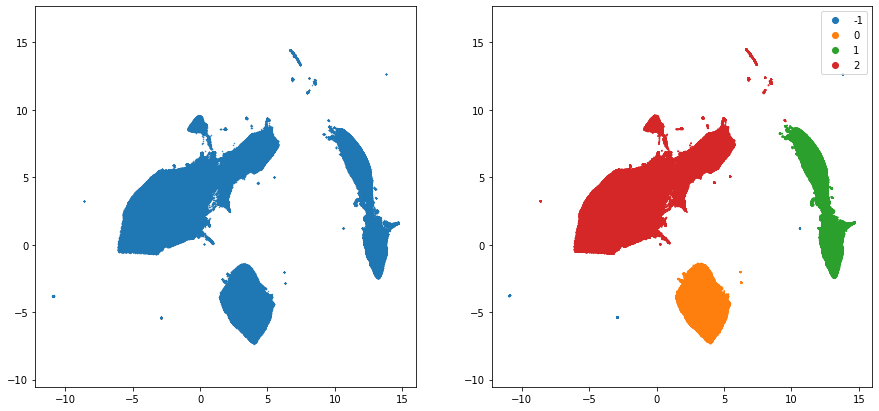

In [36]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
axes= axes.ravel()
axes[0].scatter(embedding[:, 0],embedding[:, 1], s=0.2)
axes[1].scatter(
    embedding[:, 0],
    embedding[:, 1], c=labels_c, s=1)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in c_dict.values()]
plt.legend(markers, c_dict.keys(), numpoints=1)

for ax in axes:
    ax.set_aspect('equal', 'datalim')

In [22]:
# fig.savefig('../../results/umap_hdbscan_results_19072023_1156.png')

## Cluster using UMAP and other feats

In [53]:
embedding_plus = np.hstack([embedding, df_control.filter(like='curv').abs().mean(axis=1).values.reshape(-1,1), df_control['speed_MOUTH'].values.reshape(-1,1)])
embedding_plus.shape

(1940535, 4)

In [57]:
clusterer_plus = hdbscan.HDBSCAN(
    min_samples= 1, #larger values implies more points considered as noise
    min_cluster_size= 20000, #smallest size grouping to be considered as a cluster
    prediction_data=True, 
    )

In [58]:
labels_plus = clusterer_plus.fit_predict(embedding)

In [59]:
dict_clusters_plus = {f'cluster_{i}':np.sum(labels_plus==i) for i in list(np.unique(labels_plus))}
dict_clusters_plus

{'cluster_-1': 5094,
 'cluster_0': 476188,
 'cluster_1': 321696,
 'cluster_2': 33475,
 'cluster_3': 1104082}

In [60]:
c_dict_plus = {i: c_pal[i+1] for i in np.unique(labels_plus)}
labels_plus_c = [c_dict_plus[lab] for lab in labels_plus]

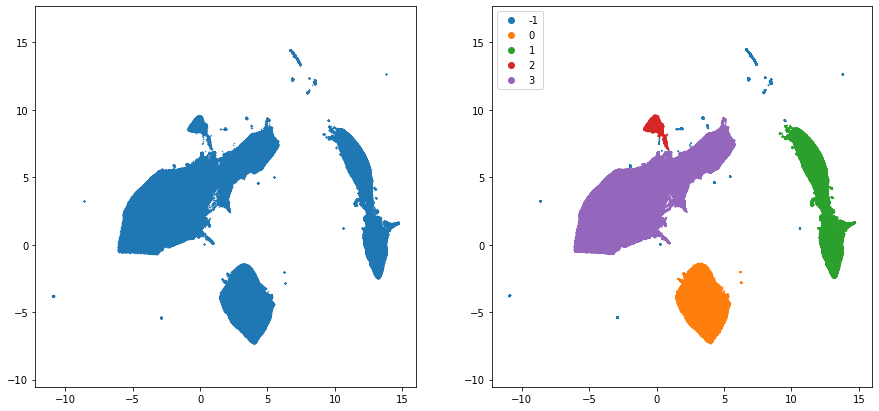

In [61]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
axes= axes.ravel()
axes[0].scatter(embedding[:, 0],embedding[:, 1], s=0.2)
axes[1].scatter(
    embedding[:, 0],
    embedding[:, 1], c=labels_plus_c, s=1)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in c_dict_plus.values()]
plt.legend(markers, c_dict_plus.keys(), numpoints=1)

for ax in axes:
    ax.set_aspect('equal', 'datalim')

In [63]:
df_results_umap['hdbscan'] = labels
df_results_umap['hdbscan_plus'] = labels_plus
df_results_umap

,umap_raw_0,umap_raw_1,hdbscan,hdbscan_plus
0,12.908291,0.926948,1,1
1,12.908686,0.909577,1,1
2,12.859251,1.195791,1,1
3,12.846456,1.272658,1,1
4,12.937160,-1.160762,1,1
...,...,...,...,...
3711897,13.202773,-1.764488,1,1
3711898,13.418066,-1.126553,1,1
3711899,12.897022,-1.398471,1,1
3711900,13.216618,-1.888046,1,1


In [64]:
df_results_umap.to_hdf('../../results/UMAP_HDBSCANclustering_19072023_1230.h5', key='features_with_results')

# Try DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
DBSCAN_cluster = DBSCAN(n_jobs=40).fit(embedding) 

In [ ]:
labels_db = DBSCAN_cluster.labels_

In [ ]:
dict_clusters_db = {f'cluster_{i}':np.sum(labels_db==i) for i in list(np.unique(labels_db))}
dict_clusters_db

In [ ]:
c_pal_10 = sns.color_palette('tab10', 10)
c_db_dict = {i: c_pal_10[i+1] for i in np.unique(labels_db)}
labels_db_c = [c_db_dict[lab] for lab in labels_db]

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(7,7))
axes= axes.ravel()

axes[1].scatter(
    embedding[:, 0],
    embedding[:, 1], c=labels_db_c, s=1)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in c_db_dict.values()]
plt.legend(markers, c_db_dict.keys(), numpoints=1)

for ax in axes:
    ax.set_aspect('equal', 'datalim')

In [ ]:
# df_control['hdbscan_clusters'] = labels

# Checking clustering results

Does each of the cluster exist in more than 1 video? else it could be some outlier / noise..

In [ ]:
df_control[['hdbscan_clusters', 'filename']].groupby('hdbscan_clusters').nunique()

In [ ]:
cols_nonfeats = ['filename', 'frame',
       'path_to_video', 'filename_video', 'date', 'time', 'light', 'drugs',
       'duration', 'age', 'stim_on', 'stim_off', 'stim_RGB', 'dlc_result_file',
       'umap_raw_0', 'umap_raw_1', 'hdbscan_clusters']

In [ ]:
df_control.filter(items=cols_nonfeats).to_hdf('../../data/umap_hdbscan_control.h5', key='control_results')

## Randomly sample each cluster and examine the postures

In [ ]:
import os
import cv2

In [ ]:
import sys 
sys.path.append('../utils/')

In [ ]:
from dlc_helper import DLC_tracking
from video_utils import get_rois, find_square_bounding

In [ ]:
import ipywidgets.widgets as widegts
from ipywidgets import interact, interact_manual

In [ ]:
df_results_control = pd.read_hdf('../../data/umap_hdbscan_control.h5')

In [ ]:
sample_fns = df_results_control.filename.sample(10)

In [ ]:
sample_fns.iloc[0]

In [ ]:
df_results_control[df_results_control['filename']==sample_fns.iloc[0]].groupby('hdbscan_clusters').nunique()

In [ ]:
def get_rois_per_video(path_to_video, path_to_dlc_coords, crop=True):
    
    

    dlc_folder, dlc_filename = os.path.split(path_to_dlc_coords)
    dlc_obj = DLC_tracking(dlc_filename, dlc_folder)
    
    dict_bbox = dlc_obj.find_bbox_dlc()
    dict_rois = {}
    
    cap = cv2.VideoCapture(path_to_video)
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    count = 0
    while count < total_frames:
        _, image = cap.read()

        count += 1
        if crop:
            # Find coords of the roi corners
            x, y, w, h = dict_bbox[count-1]
            mid_x = x + (w/2)
            mid_y = y + (h/2)
            try:
                x = int(x)
                y = int(y)
                w = int(w)
                h = int(h)
                x_new, y_new, w_new, h_new = find_square_bounding(x,y,w,h, height_max = 150, width_max = 150)
                roi_box_padded = image[y_new:y_new+h_new, x_new:x_new+w_new]
                dict_rois[count-1] = roi_box_padded

            except ValueError:
                print(f'Value Error encountered for frame {count-1}')
            except Exception as e:
                print(f'Error encountered')
                print(e)

        else:
            dict_rois[count-1] = image
            
#         cv2.waitKey(30)
            
    cap.release()
#     cv2.destroyAllWindows()
        
    return dict_rois

In [ ]:
filename = '20180724_102237_1_5m0s_None_None_None_INVERTED'
df_filename = df_results_control[df_results_control['filename']== filename]
clusters_fn = sorted(df_filename['hdbscan_clusters'].unique())
path_to_video = df_filename['path_to_video'].unique()[0]
path_to_dlc_coords = df_filename['dlc_result_file'].unique()[0]
test_dict = get_rois_per_video(path_to_video, path_to_dlc_coords)

In [ ]:
mega_dict = {i:[] for i in [-1,0,1,2,3,4,5]}

In [ ]:
df_grouped = df_filename.groupby('hdbscan_clusters')
    
for i, clus in (enumerate(clusters_fn)):

    fig, axes = plt.subplots(1, 5, figsize=(5*8, 8))
    axes = axes.ravel()
    df = df_grouped.get_group(clus)
    if len(df.index) > 5:
        df_samples = df.sample(5)
    else:
        df_samples = df

    frames = list(df_samples['frame'])

    for j, f in enumerate(frames):
        axes[j].imshow(test_dict[f])
        axes[j].set_title(f)
        
        if j == 0:
            axes[j].set_ylabel(f'cluster: {clus}')

In [ ]:
for filename in sample_fns:
    df_filename = df_results_control[df_results_control['filename']== filename]
    clusters_fn = sorted(df_filename['hdbscan_clusters'].unique())
    path_to_video = df_filename['path_to_video'].unique()[0]
    path_to_dlc_coords = df_filename['dlc_result_file'].unique()[0]
    test_dict = get_rois_per_video(path_to_video, path_to_dlc_coords)
    df_grouped = df_filename.groupby('hdbscan_clusters')

    for i, clus in (enumerate(clusters_fn)):

        df = df_grouped.get_group(clus)
        if len(df.index) > 5:
            df_samples = df.sample(5)
        else:
            df_samples = df

        frames = list(df_samples['frame'])
        for f in frames:
            mega_dict[clus].append(test_dict[f])

In [ ]:
len(mega_dict[-1])

In [ ]:
fig, axes = plt.subplots(7, 10, figsize=(35, 50))
for i, clus in enumerate(mega_dict.keys()):
    list_images_clus = mega_dict[clus]
    if len(list_images_clus) >= 10:
        sample_images = random.sample(list_images_clus, 10)
    else:
        sample_images = list_images_clus
    
    for j, img in enumerate(sample_images):
        axes[i][j].imshow(img)
        if j == 0:
            axes[i][j].set_ylabel(f'Cluster {clus}')   
    